In [1]:
training_file = 'datasets/meredig_full.data'
delimiter = ' '
comp_col = 'composition'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import re
import itertools
import pandas as pd
import matminer
import sys
sys.path.append("/Users/Ashwin/Desktop/git/matminer")
from pymatgen import Composition, Element
from matminer.descriptors.composition_features import ElementFractionAttribute
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn import datasets
from sklearn import svm
import datetime
from sklearn.multiclass import OneVsRestClassifier
%matplotlib inline

In [3]:
def load_training_set(files, sep):
    if type(files) is not list:
        training_set = pd.read_csv(files, sep=sep)
    else:
        training_set = pd.DataFrame()
        for i in range(len(files)):
            training_set.append(pd.read_csv(files[i], sep=sep[i]))
    
    return training_set

training_set = load_training_set(training_file, delimiter)

# Create PyMatGen Composition Objects

In [4]:
comp_objects = [Composition(comp) for comp in training_set[comp_col]]
training_set = training_set.assign(comp_obj=comp_objects)
training_set

,composition,delta_e,comp_obj
0,ReRu0,0.000000,(Re)
1,Re0.94444444Ru0.05555556,-0.013210,"(Re, Ru)"
2,Re0.88888889Ru0.11111111,-0.026419,"(Re, Ru)"
3,Re0.83333333Ru0.16666667,-0.039629,"(Re, Ru)"
4,Re0.77777778Ru0.22222222,-0.052839,"(Re, Ru)"
5,Re0.72222222Ru0.27777778,-0.057242,"(Re, Ru)"
6,Re0.66666667Ru0.33333333,-0.052839,"(Re, Ru)"
7,Re0.61111111Ru0.38888889,-0.048436,"(Re, Ru)"
8,Re0.55555556Ru0.44444444,-0.044032,"(Re, Ru)"
9,Re0.5Ru0.5,-0.039629,"(Re, Ru)"


## Compute element fraction descriptors with MatMiner

In [5]:
%%time

def calc_attributes(training_set):
    not_attr = list(training_set)
    training_set_updated = ElementFractionAttribute().featurize_dataframe(training_set, col_id='comp_obj')
    all_cols = list(training_set_updated)
    attr_names = [col for col in all_cols if col not in not_attr]
    return training_set_updated, attr_names
all_desc, attr_names = calc_attributes(training_set)
np.shape(all_desc)

CPU times: user 6.5 s, sys: 247 ms, total: 6.75 s
Wall time: 6.81 s


## Predicting formation energy

In [6]:
#Drop invalid rows from training_set

training_set_use = all_desc.replace("None", np.nan)
training_set_use.replace(np.inf, np.nan, inplace=True)
training_set_use.dropna(inplace=True)

np.shape(training_set_use)

(85112, 106)

In [7]:
#Discretize into pos/neg formation energy for classification

delta_e = np.array(training_set_use['delta_e'], dtype=float)

energy_range = np.zeros(np.shape(delta_e), dtype=str)
for i in range(len(delta_e)):
    if delta_e[i] < 0:
        energy_range[i] = 'neg'
    else:
        energy_range[i] = 'pos'

print(energy_range)

['p' 'n' 'n' ..., 'n' 'n' 'n']


## ML Models + KFold Cross Validation

In [8]:
from sklearn.model_selection import ShuffleSplit
def shuffle_split_cross_val(model, samples, n_splits=10, test_size=0.3):
    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state = 0)
    scores = cross_val_score(model, training_set_use[attr_names], samples, cv=cv)
    print("Average Accuracy: ", scores.mean(), ". Standard Deviation: ", scores.std())

### Random Forest Classifier

In [9]:
%%time
#Random Forest Classifier

rfc = RandomForestClassifier(n_estimators=10, criterion='gini', min_samples_split=2)
rfc.fit(training_set_use[attr_names], energy_range)
rfc_prediction = rfc.predict(training_set_use[attr_names])

CPU times: user 1.98 s, sys: 87.3 ms, total: 2.06 s
Wall time: 2.08 s


In [10]:
pd.crosstab(energy_range, rfc_prediction, rownames=['actual'], colnames=['predicted'])

predicted,n,p
actual,,
n,45475,37
p,10,39590


In [11]:
%%time
shuffle_split_cross_val(rfc, energy_range)

Average Accuracy:  0.988928487507 . Standard Deviation:  0.000536711007372
CPU times: user 18.9 s, sys: 814 ms, total: 19.7 s
Wall time: 20.7 s


### Decision Tree Classifier

In [12]:
dtc = DecisionTreeClassifier()
dtc.fit(training_set_use[attr_names], energy_range)
dtc_prediction = dtc.predict(training_set_use[attr_names])

In [13]:
pd.crosstab(energy_range, dtc_prediction, rownames=["actual"], colnames=["predicted"])

predicted,n,p
actual,,
n,45484,28
p,0,39600


In [14]:
%%time
shuffle_split_cross_val(dtc, energy_range)

Average Accuracy:  0.989954570377 . Standard Deviation:  0.000786444960759
CPU times: user 16.2 s, sys: 673 ms, total: 16.9 s
Wall time: 18.3 s


### Random Forest Regressor

In [15]:
rf_model = RandomForestRegressor()
rf_model.fit(training_set_use[attr_names], delta_e)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [16]:
rf_prediction = rf_model.predict(training_set_use[attr_names])

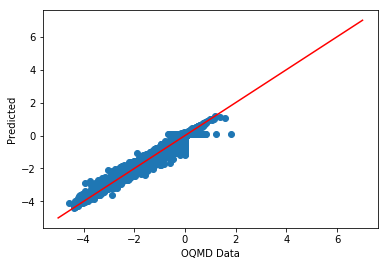

In [17]:
plt.scatter(delta_e, rf_prediction)
plt.plot(range(-5,8), range(-5,8), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [18]:
%%time
shuffle_split_cross_val(rf_model, delta_e)

Average Accuracy:  0.93957299914 . Standard Deviation:  0.00189362429286
CPU times: user 3min 4s, sys: 2.36 s, total: 3min 6s
Wall time: 3min 13s


### Decision Forest Regressor

In [19]:
dt_model = DecisionTreeRegressor()
dt_model.fit(training_set_use[attr_names], delta_e)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [20]:
dt_prediction = dt_model.predict(training_set_use[attr_names])

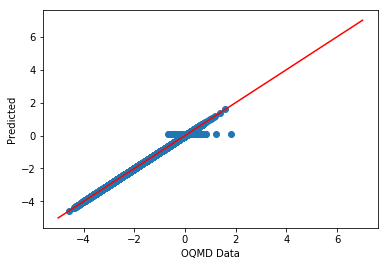

In [21]:
plt.scatter(delta_e, dt_prediction)
plt.plot(range(-5,8), range(-5,8), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [22]:
%%time
shuffle_split_cross_val(dt_model, delta_e)

Average Accuracy:  0.890500727787 . Standard Deviation:  0.00764138625857
CPU times: user 26.9 s, sys: 506 ms, total: 27.4 s
Wall time: 27.6 s


# Split Dataset by Element for Aluminum

In [23]:
cols_to_drop = ['comp', 'energy_pa', 'volume_pa', 'magmom_pa', 'bandgap', 'stability', 'comp_obj', 'is_groundstate', 'delta_e']

In [24]:
def get_elements(comp):
    return comp.elements

def split_by_element(training_set, element):
    """
    Splits dataframe into two datasets: one without the element inputted and the other with. Provides datasets for machine learning models.
    
    Args:
        training_set: pandas data frame containing training data
        element: string represenation of an element
    Returns:
        Two dataframes -- one with compounds with the element in it, the other without
    """
    #print(training_set.head())
    #for comp in training_set['comp_obj']:
        #if Element(element) in comp.elements:
        
    training_set['els'] = training_set['comp_obj'].apply(get_elements)
    training_set['is_in'] = False
    for count, el_list in enumerate(training_set['els']):
        if Element(element) in el_list:
            training_set.iloc[count, training_set.columns.get_loc('is_in')] = True
    
    with_element = training_set[training_set['is_in']]
    without_element = training_set[training_set['is_in'] == False]
    return with_element, without_element

In [25]:
%%time
#Predict Enthalpy Delta given training data without Aluminum in it
with_, without = split_by_element(training_set_use, 'Al')

CPU times: user 1.7 s, sys: 164 ms, total: 1.86 s
Wall time: 1.88 s


In [26]:
cols_to_drop += ['els', 'is_in']

In [27]:
def create_ranges(without, with_):
    # Training data

    #Discrete into pos/neg formation energy for regression
    delta_e_without = np.array(without['delta_e'], dtype=float)
    #pos/neg values for classification
    energy_range_without = np.zeros(np.shape(delta_e_without), dtype=str)
    for i in range(len(delta_e_without)):
        if delta_e_without[i] < 0:
            energy_range_without[i] = 'neg'
        else:
            energy_range_without[i] = 'pos'

    # Prediction data
    delta_e_with = np.array(with_['delta_e'], dtype=float)
    energy_range_with = np.zeros(np.shape(delta_e_with), dtype=str)
    for i in range(len(delta_e_with)):
        if delta_e_with[i] < 0:
            energy_range_with[i] = 'neg'
        else:
            energy_range_with[i] = 'pos'
            
    return delta_e_without, energy_range_without, delta_e_with, energy_range_with

In [28]:
delta_e_without, energy_range_without, delta_e_with, energy_range_with = create_ranges(without, with_)

## Classification on All Elements

In [29]:
def all_el_split(method):
    """
    Takes a machine learning model, then uses the split element test to fill a dataframe with r1 and r2 values for each element
    """
    index = ['r1', 'r2']
    stats = pd.DataFrame(index=index)
    for i in range(1, 104):
        el = Element.from_Z(i).symbol
        print(el)
        # creates two dataframes, with the element in it and without the element in it
        with_, without = split_by_element(training_set_use, el)
        # will reiterate if there are no compositions with the selected element
        if with_.shape[0] == 0:
            continue
        # creates classification data: trains with delta_e_without and energy_range_without; predicts with delta_e_with
        delta_e_without, energy_range_without, delta_e_with, energy_range_with = create_ranges(without, with_)
        r1, r2 = method(without, with_, energy_range_without, energy_range_with)
        arr = [r1, r2]
        stats[el] = pd.Series(arr).values 
        
    return stats

In [30]:
without[attr_names].head()

,Ac,Ag,Al,Am,Ar,As,At,Au,B,Ba,...,Tl,Tm,U,V,W,Xe,Y,Yb,Zn,Zr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Random Forest Classifier

In [31]:
import math
def rfc(without, with_, energy_range_without, energy_range_with):
    """
    Returns r1 score and r2 score
    """
    
    rfc = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, n_jobs=-1)
    rfc.fit(without[attr_names], energy_range_without)
    rfc_prediction = rfc.predict(with_[attr_names])
    r2_score = rfc.score(with_[attr_names], energy_range_with)
    r1_score = math.sqrt(r2_score)
    #print(pd.crosstab(energy_range_with, rfc_prediction, rownames=['actual'], colnames=['predicted']))
    print(r1_score)
    return r1_score, r2_score


In [32]:
%%time
rfc_stats = all_el_split(rfc)

H


0.6357019818679288
He


0.7625217334210179
Li


0.961951506783375
Be


0.6824121002076413
B


0.7371660652177351
C


0.6506202985677334
N


0.6100425384628331
O


0.7568868715019452
F


0.7030085272360646
Ne


0.7629355851385535
Na


0.9211489292039198
Mg


0.8833958066318109
Al


0.7646515735846668
Si


0.7464274685362142
P


0.7561704697306779
S


0.7324302138955009
Cl


0.7264831572567789
Ar


0.7625217334210179
K


0.9363189275292418
Ca


0.9784976821601695
Sc


0.9571167160375406
Ti


0.9315800608061714
V


0.908933367110506
Cr


0.8799944567452905
Mn


0.8952759280477568
Fe


0.8570728948640692
Co


0.8157549853333612
Ni


0.8260719851580526
Cu


0.8234238919472743
Zn


0.7112277032769518
Ga


0.7295760448130083
Ge


0.7463823511935611
As


0.704215412424022
Se


0.7184827422358993
Br


0.7455136397082283
Kr


0.7700277002194337
Rb


0.9225254248411994
Sr


0.9693990008662533
Y


0.975376764453605
Zr


0.9387509978443809
Nb


0.9088147065115952
Mo


0.8886558232856565
Tc


0.8221997695567604
Ru


0.7952014171338935
Rh


0.7312942311307327
Pd


0.8024254260606754
Ag


0.7567331259756699
Cd


0.7361650615326367
In


0.7991132285964635
Sn


0.747545001596402
Sb


0.7272754668134603
Te


0.731488200796962
I


0.7206772320299951
Xe


0.7708573833904935
Cs


0.9228422210391994
Ba


0.9691854251635827
La


0.9898936264337181
Ce


0.9932304599772838
Pr


0.9938902336828597
Nd


0.9946808133388334
Pm


0.9557772235254934
Sm


0.9861575627375548
Eu


0.9764354173200612
Gd


0.9880732056855982
Tb


0.9321694038903447
Dy


0.990266768225264
Ho


0.9800572805772018
Er


0.982160162877431
Tm


0.984517010019004
Yb


0.987831405201163
Lu


0.9857792842934937
Hf


0.9329989850033021
Ta


0.9035714921584465
W


0.8604232988616217
Re


0.8270597183866336
Os


0.7393325524050351
Ir


0.7027564774989034
Pt


0.7499357959165027
Au


0.7301109880928214
Hg


0.6530537522138657
Tl


0.7193255131717365
Pb


0.6893225391019122
Bi


0.7104033341674725
Po


At


Rn


Fr


Ra


Ac


0.9728340315611035
Th


0.9712296520581716
Pa


0.9307687096806354
U


0.9337728293889345
Np


0.9346269781815092
Pu


0.9683050546697991
Am


Cm


Bk


Cf


Es


Fm


Md


No


Lr


CPU times: user 45min 22s, sys: 39 s, total: 46min 1s
Wall time: 15min 6s


In [33]:
rfc_stats

,H,He,Li,Be,B,C,N,O,F,Ne,...,Hg,Tl,Pb,Bi,Ac,Th,Pa,U,Np,Pu
r1,0.635702,0.762522,0.961952,0.682412,0.737166,0.650620,0.610043,0.756887,0.703009,0.762936,...,0.653054,0.719326,0.689323,0.710403,0.972834,0.971230,0.930769,0.933773,0.934627,0.968305
r2,0.404117,0.581439,0.925351,0.465686,0.543414,0.423307,0.372152,0.572878,0.494221,0.582071,...,0.426479,0.517429,0.475166,0.504673,0.946406,0.943287,0.866330,0.871932,0.873528,0.937615


In [34]:
rfc_stats.T['r2'].describe()

count    89.000000
mean      0.718619
std       0.189556
min       0.372152
25%       0.543414
50%       0.682395
75%       0.913510
max       0.989390
Name: r2, dtype: float64

### Decision Forest Classifier

In [35]:
def dtc(without, with_, energy_range_without, energy_range_with):
    dtc = DecisionTreeClassifier()
    dtc.fit(without[attr_names], energy_range_without)
    dtc_prediction = dtc.predict(with_[attr_names])
    r2_score = dtc.score(with_[attr_names], energy_range_with)
    r1_score = math.sqrt(r2_score)
    #print(pd.crosstab(energy_range_with, dtc_prediction, rownames=['actual'], colnames=['predicted']))
    print(r1_score)
    return r1_score, r2_score

In [36]:
%%time
dfc_stats = all_el_split(dtc)

H


0.630138680156746
He


0.7554515674132066
Li


0.958037406024778
Be


0.6900021312840059
B


0.7420337907050277
C


0.6444677225574037
N


0.5991555238601677
O


0.7605811698718912
F


0.7059616682389022
Ne


0.7554515674132066
Na


0.9208757128463737
Mg


0.8787585262729725
Al


0.7684918413001712
Si


0.7508419328241409
P


0.7640182608123369
S


0.7380643754914006
Cl


0.7307556578074675
Ar


0.7554515674132066
K


0.934321444875392
Ca


0.9756124126428058
Sc


0.9596923076111358
Ti


0.932761519823495
V


0.9135340378079243
Cr


0.8790490729915326
Mn


0.8901713673732374
Fe


0.8550707195065754
Co


0.8107314720336205
Ni


0.8222230557277879
Cu


0.8187817703417354
Zn


0.7056022969688938
Ga


0.7351267145640987
Ge


0.7516386298755937
As


0.7096482058683548
Se


0.7229198194313344
Br


0.7387442000620583
Kr


0.7630403815123584
Rb


0.9184392150683277
Sr


0.9657040279831711
Y


0.9804575825244594
Zr


0.944006876541516
Nb


0.9160133513055991
Mo


0.8886558232856565
Tc


0.8195432205458594
Ru


0.7892939372608762
Rh


0.7254942786198518
Pd


0.7974855883326835
Ag


0.7507314155734381
Cd


0.7298491204092059
In


0.7953594690973842
Sn


0.7523718152724022
Sb


0.7325600083700082
Te


0.7377445721257567
I


0.7139242511521848
Xe


0.7638996750672428
Cs


0.9217976907429088
Ba


0.9654215840509556
La


0.9984905651773154
Ce


0.9989999997498749
Pr


0.9944230079016011
Nd


0.9954805032549571
Pm


0.9504783484693857
Sm


0.9954072430492079
Eu


0.9758870120999864
Gd


0.9898974225729122
Tb


0.9290206574627613
Dy


0.9950137466492321
Ho


0.989539741873496
Er


0.9903328886638143
Tm


0.9898930589495133
Yb


0.9853238612759665
Lu


0.990262669718878
Hf


0.9382053220702979
Ta


0.914103706143666
W


0.8546130254168797
Re


0.8214429490345135
Os


0.7393325524050351
Ir


0.7000952316173374
Pt


0.7434010324299909
Au


0.7241650750700215
Hg


0.6453837702455101
Tl


0.7159100733440398
Pb


0.6832916048207698
Bi


0.7026221210364527
Po


At


Rn


Fr


Ra


Ac


0.9673092905354088
Th


0.9792405409484624
Pa


0.9391982306837817
U


0.9420226201436601
Np


0.9289715930569447
Pu


0.9736591972635508
Am


Cm


Bk


Cf


Es


Fm


Md


No


Lr


CPU times: user 4min 19s, sys: 8.11 s, total: 4min 27s
Wall time: 4min 29s


In [37]:
dfc_stats

,H,He,Li,Be,B,C,N,O,F,Ne,...,Hg,Tl,Pb,Bi,Ac,Th,Pa,U,Np,Pu
r1,0.630139,0.755452,0.958037,0.690002,0.742034,0.644468,0.599156,0.760581,0.705962,0.755452,...,0.645384,0.715910,0.683292,0.702622,0.967309,0.979241,0.939198,0.942023,0.928972,0.973659
r2,0.397075,0.570707,0.917836,0.476103,0.550614,0.415339,0.358987,0.578484,0.498382,0.570707,...,0.416520,0.512527,0.466887,0.493678,0.935687,0.958912,0.882093,0.887407,0.862988,0.948012


In [38]:
dfc_stats.T['r1'].describe()

count    89.000000
mean      0.839971
std       0.115119
min       0.599156
25%       0.738744
50%       0.821443
75%       0.950478
max       0.999000
Name: r1, dtype: float64